In [4]:
import numpy as np
import pandas as pd

In [5]:
data=pd.read_csv('mitbih_train.csv')

In [6]:
DF=pd.DataFrame(data)

In [27]:
import matplotlib.pyplot as plt

In [8]:
new_column_name = ['label']
for num in range(DF.shape[1]-1):
    tem = 'dim' + str(num)
    new_column_name.append(tem)
DF.columns = new_column_name    


In [19]:
train_MI=DF.iloc[0:7000]
test_MI=DF.iloc[7000:9000]

In [18]:
train=np.asarray(train_MI)
train=train.reshape(7000, 188, 1)

In [17]:
test=np.asarray(test_MI)
test=test.reshape(2000, 188, 1)

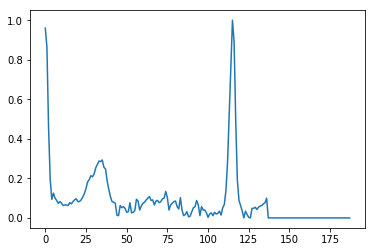

In [94]:
fig=plt.plot(train[0])
plt.savefig('images_ecg/1.png')

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 =90
        hidden_2 =40
        hidden_3=25
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(188,90)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(90, 40)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(40, 25)
        self.fc4=nn.Linear(25,40)
        self.fc5=nn.Linear(40,90)
        self.fc6=nn.Linear(90,188)
        self.dropout = nn.Dropout(0.2)

    def encoder(self, x):
        x=x.squeeze()
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x=F.relu(x)
        x=self.dropout(x)
        return x
    def decoder(self,x):
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        x=x.view(-1)
        return x
# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=188, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=40, bias=True)
  (fc5): Linear(in_features=40, out_features=90, bias=True)
  (fc6): Linear(in_features=90, out_features=188, bias=True)
  (dropout): Dropout(p=0.2)
)


In [14]:
model.double()

Net(
  (fc1): Linear(in_features=188, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=40, bias=True)
  (fc5): Linear(in_features=40, out_features=90, bias=True)
  (fc6): Linear(in_features=90, out_features=188, bias=True)
  (dropout): Dropout(p=0.2)
)

In [39]:
# specify loss function (categorical cross-entropy)
criterion = nn.MSELoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.06)

Epoch: 1 	Training Loss: 7.066212 	Validation Loss: 8.077022
Epoch: 2 	Training Loss: 6.871409 	Validation Loss: 8.077101
Epoch: 3 	Training Loss: 6.871416 	Validation Loss: 8.077101


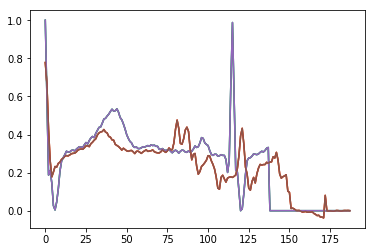

In [40]:
# number of epochs to train the model
n_epochs = 3

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    model.train() # prep model for training
    for i in range(len(train)):
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        b=torch.from_numpy(train[i])
        compressed = model.encoder(b)
        output=model.decoder(compressed)
        # calculate the loss
        loss = criterion(output,b.squeeze())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*b.size(0)
    model.eval() # prep model for evaluation
    for j in range(len(test)):
        # forward pass: compute predicted outputs by passing inputs to the model
        c=torch.from_numpy(train[i])
        compressed = model.encoder(c)
        output=model.decoder(compressed)
        # calculate the loss
        loss = criterion(output,c.squeeze())
        # update running validation loss 
        valid_loss += loss.item()*c.size(0)
        if j==len(test)-1:
            plt.plot(test[j])
            plt.plot(output.detach().numpy())
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train)
    valid_loss = valid_loss/len(test)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))